# Ensemble Learning and Random Forests

Suppose you ask a complex question to thousands of random people, then aggregate their answers.  In many cases you will find that this aggregated answer is better than an expert's answer.  This is called the wisdom of the crowd.  Similarly, if you aggregate the prediction of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor.  A group of predictors is called an **ensemble**; thus, this technique is called *Ensemble Learning*, and an Ensemble Learning algorithm is called an *Ensemble Method*.

For example, you can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, you just obtain the predictions of all indiviual trees, then predict the class that gets the most votes.  Such an ensemble of Decision Trees is called a *Random Forest*, and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today.

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# # Where to save the figures
# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "ensembles"

# def image_path(fig_id):
#     return os.path.join(PROJECT_ROOT_DIR, "saved_images", fig_id)

# def save_fig(fig_id, tight_layout=True):
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

## Voting Classifiers

Suppose you have trained a few classifers, each one achieving about 80% accuracy.  You may have a Logistic Regression classifier, an SVM classifier, a Random Forest classifier, a K-Nearest Neighbors classifier, ect...

A very simple way to create an even better classifier is to aggregate the predicitons of each classifer and prdict the class that gets the most votes.  The majority vote classifier is called a **hard voting** classifier.  Somewhat surprisingly, this voting classifier oftern achieves a higher accuracy than the best classifer in the ensemble.  In fact, even if each classifier is a *weak learner* (meaning it only does slightly better than random guessing), the enseble can still be a *strong learner* (achieving high accuracy), provided there are a sufficient number of weak learners and they are sufficiently diverse.

The following analogy can help shed some light on this mystery.  Suppose you ahve a slighly biased coin that has a 51% chance of coming up heads, and 49% chance of coming up tails.  If you toss it 1,000 times, you will generally get more or less 510 heads and 490 tails, and hence a majority of heads.  If you do the math, you will find that the probability of obtaining a majority of heads after 1,000 tosses is close to 75%.  The more you toss the coin, the higher the probability.  This is due to the *law of large numbers*: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%)

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

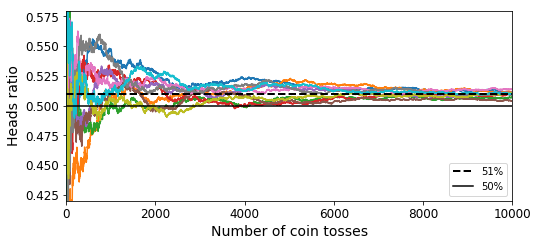

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
# save_fig("law_of_large_numbers_plot")
plt.show()

The following code creates and trains a voting classifier in Scikit_Learn, composed of three diverse classifiers.

The voting classifier slightly out performs all the individual classifiers.

If all classifiers are able to estimate class probabilities (ie., they have a **predict_proba** method), then you can tell Scikit-Learn to preict the class with the highest probability, averaged over all the individual classifiers.  This is called a **soft voting**.  It often achieves higher performance than hard voting because it gives more weight to highly confident votes.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
# Hard voting

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


In [7]:
# Soft voting 

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
#You need to set probability to True to allow for soft voting.  SVC probability is default to False
svm_clf = SVC(probability=True, random_state=42) 

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


## Bagging and Pasting

One way to get a diverse set of classifiers is to use avery different training algorithms (as in the **voting** example). Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set.  

When sampling is perfromed with replacement, this method is called *bagging* (short for *bootstrap aggregating*). 

When sampling is performed without replacement, it is called *pasting*.

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors.  The aggresggation functoin is typically the statistcal mode (i.e. the most frequent prediction, just like a hard voting classifier) fro classification, or the average for regression. Each individual predictor has a higher bias than if it were trained on teh original training set, but aggregation reduces both bias and variance.  Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trainied on the original training set.

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [11]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [12]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

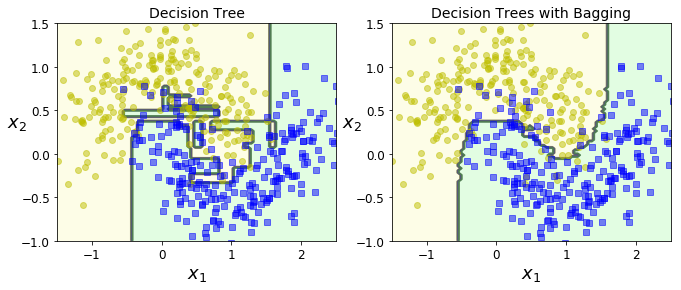

In [13]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
# save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting, but this also means that predictors end up being less correlated so the ensemble's variance is reduced.  Overall, bagging often results in better models, which explains why it is generally preferred.  However, if you have spare time and CPU power you can use cross-validation to evaluate both bagging and pasting and select the one that works the best.

## Out-of-Bag evaluation

With bagging, some instances may be sampled several times for any given predictor, while otheres may not be sampled at all.  The training instances that are not sampled are called **out-of-bag** (oob) instances.

Since a predictor never sees the oob instances during training, it can be evaluted on these instances, whitout the need for a separate validation set or cross-validation.  You can evaluate the ensemble itself by averageing out the oob evaluations of each predictor.


In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40) #set oob_score to True
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.90133333333333332

In [15]:
bag_clf.oob_decision_function_

array([[ 0.31746032,  0.68253968],
       [ 0.34117647,  0.65882353],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.08379888,  0.91620112],
       [ 0.31693989,  0.68306011],
       [ 0.02923977,  0.97076023],
       [ 0.97687861,  0.02312139],
       [ 0.97765363,  0.02234637],
       [ 0.74404762,  0.25595238],
       [ 0.        ,  1.        ],
       [ 0.71195652,  0.28804348],
       [ 0.83957219,  0.16042781],
       [ 0.97777778,  0.02222222],
       [ 0.0625    ,  0.9375    ],
       [ 0.        ,  1.        ],
       [ 0.97297297,  0.02702703],
       [ 0.95238095,  0.04761905],
       [ 1.        ,  0.        ],
       [ 0.01704545,  0.98295455],
       [ 0.38947368,  0.61052632],
       [ 0.88700565,  0.11299435],
       [ 1.        ,  0.        ],
       [ 0.96685083,  0.03314917],
       [ 0.        ,  1.        ],
       [ 0.99428571,  0.00571429],
       [ 1.        ,  0.        ],
       [ 0.        ,

In [16]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.91200000000000003

According to this oob evaluation, this BaggingClassifier is likely to achieve 90.1% accuracy on the test set.  When run we got 91.2% accuracy.

We can also evaluate the predictions of each training instance through the oob_decision_function__

## Random Patches and Random Subspaces

The BaggingClassifier class supports sampling the features as well.  This is controlled by two hyperparamters: **max_features** and **bootstrap_features**.  They work the same way as **max_samples** and **bootstrap**, but for feature sampling instead of instance sampling.  Thus, each predictor will be trainied on a random subset of the input features.

This is particularly useful when you are dealing with high-dimensional inputs (such as images).  Sampling both training instances and features is called the *Random Patches* method.  Keeping all training instances but sampling features is called the *Random Subspaces* method.

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

## Random Forests 

Random forest is an ensemble of Decision Trees, generally trained via the bagging method, typically with **max_samples** set to the size of the training set.  Instead of using DecisionTreeClassifier, you can instaed use the RandomForestClassifier class, which is more convinient and optimized for Decision Trees.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature amoung a random subset of features.  This results in a greater tree diversity, which trades a higher bias for a lower variance, generally yielding an overall better model.

In [17]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [18]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [19]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [20]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.97599999999999998

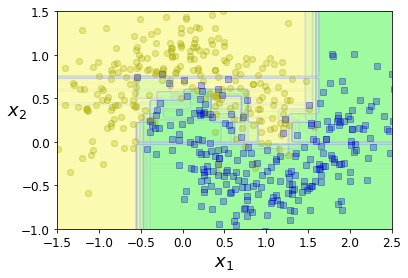

In [21]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

## Extra-trees

When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting.  It is possible to make the trees even more random by also using random thresholds for each thresholds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do).

A forest of such extremely random trees is simple called an *Extremely Randomized Tree* ensemble (Extra-trees for short).  Once agian, this trades more bias for a lower variance.  It also makes Extra-Trees much faster to train than regular Random Forests since finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

You can create and Extra-Tree classifier using Scikit-Learn's ExtraTreesClassifier class.

## Feature Importance

If you look at a single Decision Tree, important features are likely to appear closer to the root of the tree, while un-important will often appear closer to the leaves.  It is therefore possible to get an estimate of a feature's importance by computing the average depth at which it appears across all tress in the forest.

Scikit-Learn computes this automatically for every feature after training. You can access the results using the feature_importances__ variable.  

In [22]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.112492250999
sepal width (cm) 0.0231192882825
petal length (cm) 0.441030464364
petal width (cm) 0.423357996355


In [23]:
rnd_clf.feature_importances_

array([ 0.11249225,  0.02311929,  0.44103046,  0.423358  ])

In [24]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [25]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

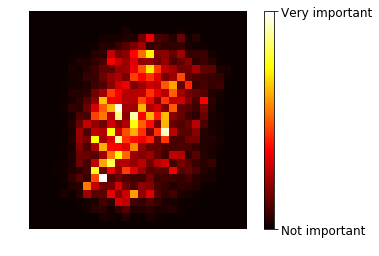

In [26]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")
    
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

# save_fig("mnist_feature_importance_plot")
plt.show()

Similarly, if you train a Random Forest classifier on the MNIST datset and plot each pixel's importance, you get the above image.

# Boosting

Combining several weak learners into one strong learner.  The general idea of most boosting methoods is to train predictors sequentially, wach trying to correct its predecessor.

## AdaBoost

One way for a new predictor to correct its predecssor is to pay a bit more attention to the training instances that the predessor underfitted.  This results in new predictors focusing more and more on the hard cases.


In [27]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

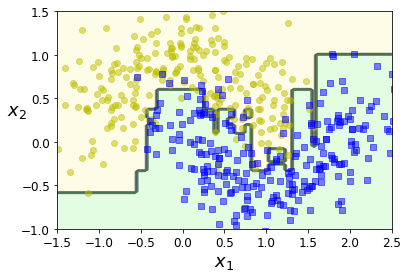

In [28]:
plot_decision_boundary(ada_clf, X, y)

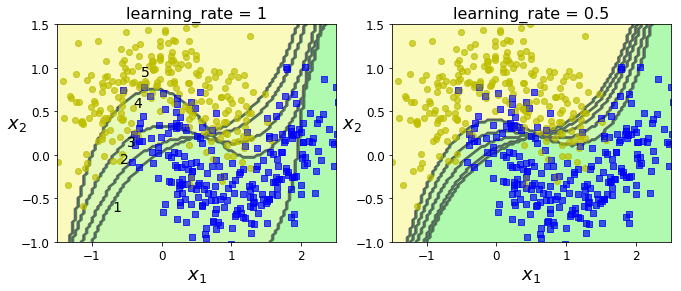

In [29]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    for i in range(5):
        plt.subplot(subplot)
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

plt.subplot(121)
plt.text(-0.7, -0.65, "1", fontsize=14)
plt.text(-0.6, -0.10, "2", fontsize=14)
plt.text(-0.5,  0.10, "3", fontsize=14)
plt.text(-0.4,  0.55, "4", fontsize=14)
plt.text(-0.3,  0.90, "5", fontsize=14)
# save_fig("boosting_plot")
plt.show()

## Gradient Boost

Another popular Boosting algorithm is **Gradient Boost**. It works by sequentially adding predictors to an ensemble, each one correcting its predicessor.  However, instead of ttweaking the instance weights at every iteration like AdaBoost does, this method tires to fit the new predictor to the reisidual errors made by the previous predictor.

In [31]:
np.random.seed(42)
X = np.random.rand(1000, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(1000)

In [32]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [33]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [34]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [35]:
X_new = np.array([[0.8]])

In [36]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [37]:
y_pred

array([ 0.7382813])

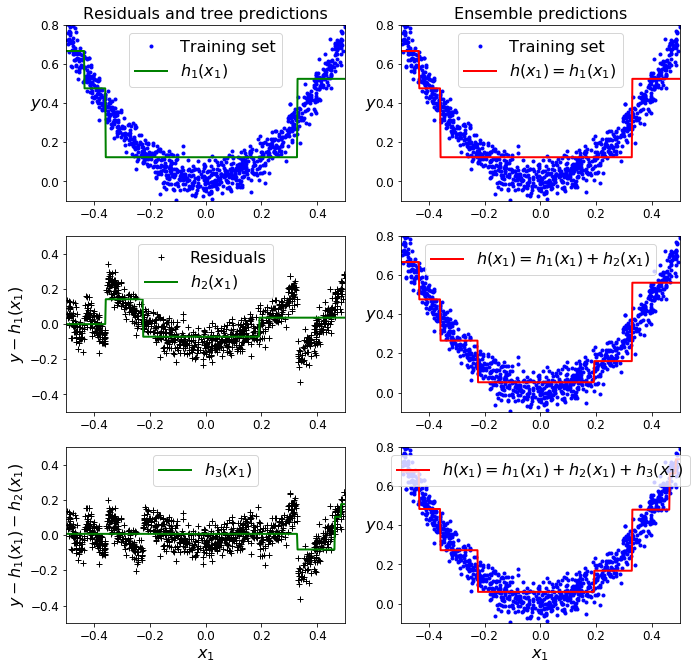

In [38]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

# save_fig("gradient_boosting_plot")
plt.show()

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [40]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

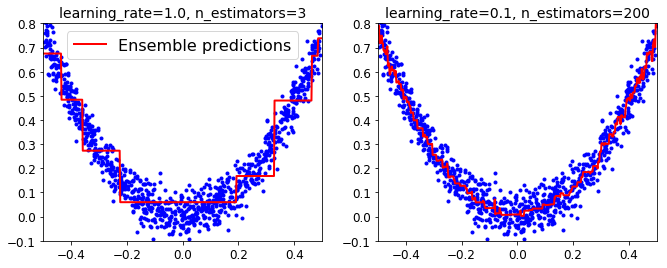

In [41]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

# save_fig("gbrt_learning_rate_plot")
plt.show()

The learning_rate hyperparamter scales teh contribution of each tree.  If you set it to a low value, such as 0.1, you will need more trees to thte ensemble to fit the training set, but the predictions will usually generalize better.  This is a regularization technique called **shrinkage**. The above graphs: the one on the left does not have enough trees to fit the training set, the one on the right has too many and overfits the data.

In order to find the optimal number of trees, you can use early stopping.  

In [42]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [43]:
min_error = np.min(errors)

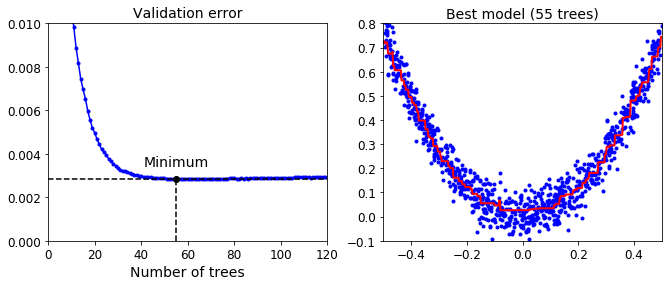

In [44]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

# save_fig("early_stopping_gbrt_plot")
plt.show()

It is also possible to implement early stopping by actually stopping training early (instead of running a large number then assessing). You can do so by setting **warm_state = True**, which makes Scikit-Learn keep existing trees when the fit() method is called, allowing incremental training.  The following code stops training when the validation error does not improve for five iterations in a row

In [45]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

print(gbrt.n_estimators)

61
